# Python Pointers, Vol. 4

## Colorbars til you cry

In [20]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## Data Source

Here I used my own local files on my laptop. You'll need to change that.

If you want to exactly duplicate it, I copied these files to glade:
`/glade/work/brianpm/observations/ceres/`

But caution: make sure that the files identified in the next cell are only:
- `CERES_EBAF_Ed4.2_Subset_200003-201412.nc`
- `CERES_EBAF_Ed4.2_Subset_201501-202309.nc`

## Plotting Methods

Following loading the data, we just make a long-term average. It is the average of all months in the record, but weighted by the days in each month. 

Once we have the climatology, plot it several ways:
- using the xarray `plot` methods: quick and dirty
- `plt.subplots`: concise
- `plt.figure()` and `add_subplot`: explicit
- more use of `plt` interface

In the latter cases, add a colorbar and use a few of the basic features.


In [21]:
# CERES data just as an example
loc = Path("/Users/brianpm/Library/CloudStorage/Dropbox/Data/CERES/Ed4.2/")
# on glade:
# loc = Path("/glade/work/brianpm/observations/ceres/")
fils = sorted(loc.glob("CERES_EBAF_Ed4.2_Subset_*.nc"))
ds = xr.open_mfdataset(fils)

In [22]:
# Get the annual mean net CRE
x = ds['toa_cre_net_mon'].weighted(ds.time.dt.daysinmonth).mean(dim='time')
s = ds['toa_cre_sw_mon'].weighted(ds.time.dt.daysinmonth).mean(dim='time')
t = ds['toa_cre_lw_mon'].weighted(ds.time.dt.daysinmonth).mean(dim='time')

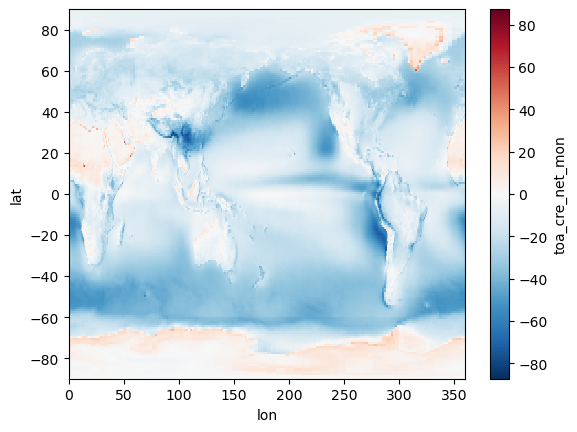

In [23]:
# Quick look : use xarray

x.plot.pcolormesh()

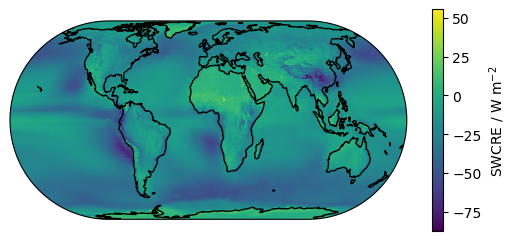

In [24]:
# Use matplotlib and cartopy 

# Set up the elements: method 1: subplots()
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.EckertIV()})

# projection kwarg will make each element of ax a Cartopy GeoAxes object.

# It is much faster (and it will end up being right more often) to give MPL an idea of the grid:
longrid, latgrid = np.meshgrid(ds['lon'], ds['lat'])

img = ax.pcolormesh(longrid, latgrid, x, transform=ccrs.PlateCarree())

ax.coastlines()  # Cartopy method to add coastlines

fig.colorbar(img, shrink=0.6, label='SWCRE / W m$^{-2}$')


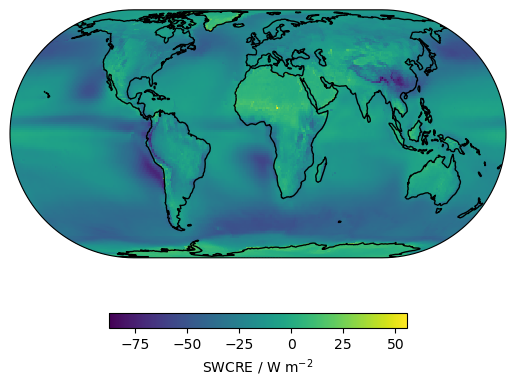

In [25]:
# Set up the elements: method 2: Figure and Axes in separate steps
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.EckertIV())

# (nrows, ncols, index) -  index starts at 1 in the upper left corner

longrid, latgrid = np.meshgrid(ds['lon'], ds['lat'])

img = ax.pcolormesh(longrid, latgrid, x, transform=ccrs.PlateCarree())

ax.coastlines()  # Cartopy method to add coastlines


# Change the colorbar to be horizontal:
fig.colorbar(img, shrink=0.6, label='SWCRE / W m$^{-2}$', orientation='horizontal')


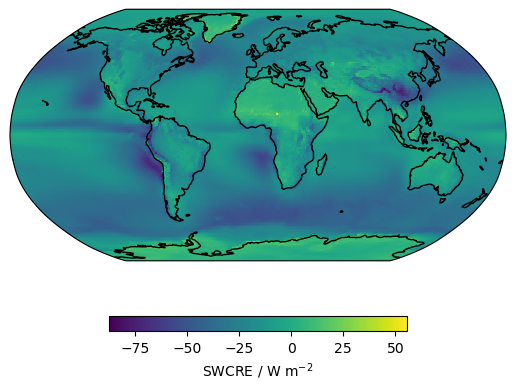

In [76]:
# Set up the elements: method 3: use the pyplot interface 
ax = plt.axes(projection=ccrs.Robinson()) # CHANGE projection, just for fun (this is just a slight change)
ax.coastlines()

longrid, latgrid = np.meshgrid(ds['lon'], ds['lat'])

img = ax.pcolormesh(longrid, latgrid, x, transform=ccrs.PlateCarree())
# Equivalent: img = plt.pcolormesh(longrid, latgrid, x, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.6, label='SWCRE / W m$^{-2}$', orientation='horizontal')


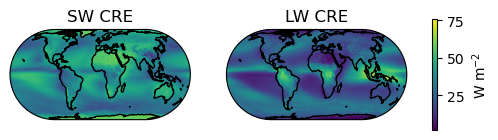

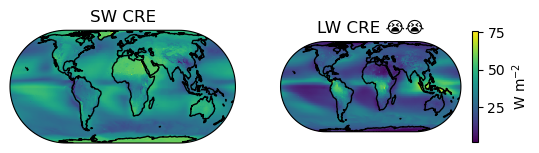

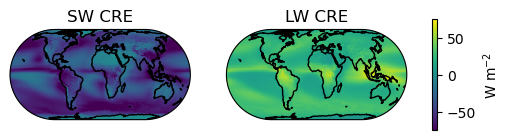

In [27]:
# Make a 2-panel plot with one colorbar

fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})

# It is much faster (and it will end up being right more often) to give MPL an idea of the grid:
longrid, latgrid = np.meshgrid(ds['lon'], ds['lat'])

img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree())
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree())

ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")

[a.coastlines() for a in ax]

fig.colorbar(img2, ax=ax, shrink=0.3, label='W m$^{-2}$') 
# note: shrink has to be changed to fit with the two panels
# note: ax kwarg is the Axes to attach the colorbar to, and can be multiple Axes (2 here)
#       If you attach to just one of them, 
#       only that map will get rescaled to make room for the colorbar,
#       as shown next.

plt.show(fig)
plt.close(fig)


# Example of WRONG SCALING:
fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree())
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree())
ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE 😭😭")
[a.coastlines() for a in ax]
fig.colorbar(img2, ax=ax[-1], shrink=0.3, label='W m$^{-2}$') 
plt.show(fig)
plt.close(fig)



# NOTE: we supplied 'img2' as the source of color for BOTH panels, 
#       but we didn't control the range of values... SO IT'S WRONG!
#       These first two figures have the colorbar for the LW panel,
#       but no way to decode the colors in the SW panel.

# Correct this by using the same "normalization" for both panels

color_norm = mpl.colors.Normalize(vmin=-75, vmax=75)

fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=color_norm)
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=color_norm)
ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]
fig.colorbar(img2, ax=ax, shrink=0.3, label='W m$^{-2}$') 
plt.show(fig)
plt.close(fig)

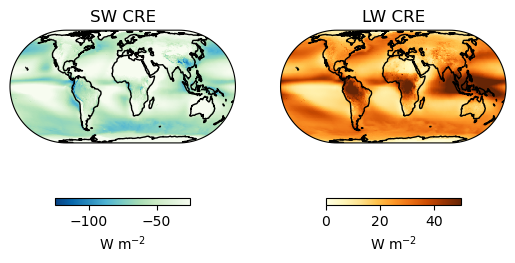

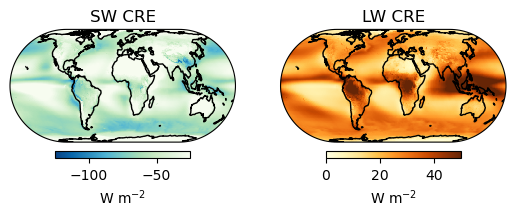

In [28]:
# Same plot, but now use two different colorscales

# Control the colors using mpl.colors.Normalize

shortwave_norm = mpl.colors.Normalize(vmin=-125, vmax=-25)
longwave_norm = mpl.colors.Normalize(vmin=0, vmax=50)

fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
longrid, latgrid = np.meshgrid(ds['lon'], ds['lat'])
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=shortwave_norm, cmap='GnBu_r') # "_r" REVERSES THE COLORMAP
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=longwave_norm, cmap='YlOrBr')

ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")

[a.coastlines() for a in ax]

# Note: you can name the colorbars if you want to access them later
cb1 = fig.colorbar(img1, ax=ax[0], shrink=0.6, label='W m$^{-2}$', orientation='horizontal') 
cb2 = fig.colorbar(img2, ax=ax[1], shrink=0.6, label='W m$^{-2}$', orientation='horizontal') 
plt.show(fig)
plt.close(fig)

# Repeat, but let's get the colorbars much closer to the maps:
# (using the `pad` kwarg)
fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=shortwave_norm, cmap='GnBu_r') # "_r" REVERSES THE COLORMAP
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=longwave_norm, cmap='YlOrBr')
ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]

fig.colorbar(img1, ax=ax[0], shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 
fig.colorbar(img2, ax=ax[1], shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 

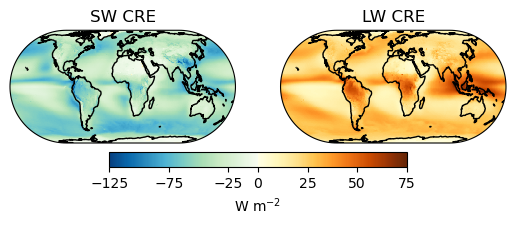

In [29]:
# Similar plot, but make our own colormap by combining those two:
combine_colors = np.vstack((mpl.cm.GnBu_r(np.linspace(0,1,128)), mpl.cm.YlOrBr(np.linspace(0,1,128))))
mycmap = mpl.colors.LinearSegmentedColormap.from_list('new_colormap', combine_colors)

# notes:
# np.vstack - "vertically stack" two arrays
# np.linspace - linearly spaced values
# mpl.cm.YlOrBr - direct access to the Matplotlib colormap,
#                 the colormaps are instances of LinearSegmentedColormap,
#                 which can take an argument to get the RGBA color data.
#                 Here we specify 128 values from 0 to 1 to get color values
#                 from the colormap. 
#                 `mpl.cm.YlOrBr?` for details
# mpl.colors.LinearSegmentedColormap.from_list() -- Use the array of color values to make a new colormap.

cnorm = mpl.colors.TwoSlopeNorm(vmin=-125, vcenter=0, vmax=75)
# TwoSlopeNorm allows a very easy way to hav asymmetric colorbars.

fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=cnorm, cmap=mycmap) # "_r" REVERSES THE COLORMAP
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=cnorm, cmap=mycmap)
ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]


cb = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=mycmap), ax=ax, shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 
cb.ax.set_xticks([-125, -75, -25, 0, 25, 50, 75]);


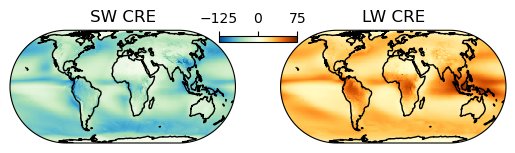

In [74]:
# Put the colorbar in an arbitrary place

# --> USE `inset_axes` to put a new Axes object inside the GeoAxes
# position it and then put the colorbar in the new Axes object.

fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=cnorm, cmap=mycmap) # "_r" REVERSES THE COLORMAP

img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=cnorm, cmap=mycmap)
ax[0].set_title("SW CRE", y=1.0)  # NOTE: the colorbar placement affected the automatic position of the title, so set it explicitly.
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]

# The colorbar is really just another Axes object, so can be placed anywhere.
# Using inset_axes make this new Axes object a child of already existing Axes
cax = ax[0].inset_axes([0.925, .90, 0.35, 0.05])  # THE NEW AXES, x, y, width, height, 
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=mycmap), cax=cax, orientation='horizontal')
cbar.ax.set_xticks([-125, 0, 75])
cbar.ax.xaxis.set_ticks_position('top')
# https://matplotlib.org/stable/users/explain/axes/colorbar_placement.html

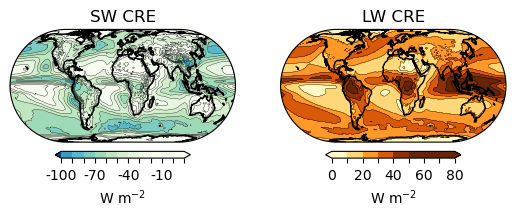

In [73]:
# Bonus based on Adam's question:
# (a) Contour lines
# (b) "discrete" colorbar
# There are a couple of ways to make colorbar that shows only a limited set of colors

fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})

# Change pcolormesh to contourf to get a "filled contour plot"
# Use explicit levels via the levels kwarg
# also add the "extend" kwarg to make any values outside the range be 
# colored in the extreme end of the colorbar

swlevels = np.linspace(-100, 10, 12)
lwlevels = np.linspace(0, 80, 9)
img1 = ax[0].contourf(longrid, latgrid, s, 
                        levels=swlevels,
                        transform=ccrs.PlateCarree(), 
                        norm=shortwave_norm, 
                        cmap='GnBu_r',
                        extend='both') # "_r" REVERSES THE COLORMAP
# Add contour lines:
ax[0].contour(longrid, latgrid, s, 
                        levels=swlevels,
                        transform=ccrs.PlateCarree(),
                        colors='black',
                        linestyles='solid',
                        linewidths=0.25)

img2 = ax[1].contourf(longrid, latgrid, t, 
                        transform=ccrs.PlateCarree(), 
                        norm=longwave_norm, 
                        cmap='YlOrBr',
                        levels=lwlevels,
                        extend='both')

ax[1].contour(longrid, latgrid, t, 
                        transform=ccrs.PlateCarree(),
                        levels=lwlevels,
                        colors='black',
                        linestyles='solid',
                        linewidths=0.25)        


ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]

# explicitly set the tickmarks to correspond to the levels
cbarsw = fig.colorbar(img1, ax=ax[0], shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 

# Set the ticks at the values of the levels.
# The tick labels were too crowded, so I decided to space them out using a simple loop:
# [f(x) if condition else g(x) for x in sequence]
# I still didn't like the way it looked, so I also convert to integers
cbarsw.set_ticks(swlevels, labels=[np.rint(val).astype(int) if i%3==0 else "" for i, val in enumerate(swlevels)])

cbarlw = fig.colorbar(img2, ax=ax[1], shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 
cbarlw.set_ticks(lwlevels, labels=[np.rint(val).astype(int) if i%2==0 else "" for i, val in enumerate(lwlevels)])

# NOTE: I think there is some contour magic happening at the extremes, stretching to fit.
# I didn't try to fix that, but I'm sure it must be pretty easy to control. 

## Alternative sources for colormaps

- colorcet -- https://colorcet.holoviz.org -- `conda install colorcet`
- CMasher -- https://cmasher.readthedocs.io -- `conda install cmasher`
- cmocean -- https://matplotlib.org/cmocean/ -- `conda install cmocean`
- Palettable -- https://jiffyclub.github.io/palettable/ -- `conda install palettable`
- "Colormaps" -- https://pratiman-91.github.io/colormaps/ -- `conda install colormaps`

### Resources for colormaps
- https://colorbrewer2.org
- https://matplotlib.org/stable/users/explain/colors/colormaps.html
- https://www.fabiocrameri.ch/colourmaps/
- https://www.kennethmoreland.com/color-advice/
- https://datoviz.org/reference/colormaps/
- https://seaborn.pydata.org/tutorial/color_palettes.html
- Zhou L, Hansen CD. A Survey of Colormaps in Visualization. IEEE Trans Vis Comput Graph. 2016 Aug;22(8):2051-69. doi: 10.1109/TVCG.2015.2489649.



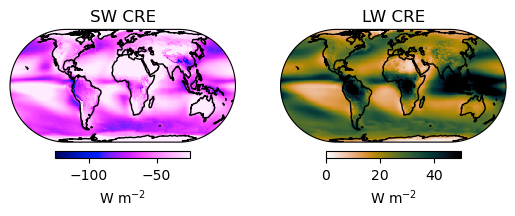

In [31]:
# Example
import colorcet as cc
import cmasher as mash
fig, ax = plt.subplots(ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=shortwave_norm, cmap=cc.cm.bmw) # "_r" REVERSES THE COLORMAP
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=longwave_norm, cmap=mash.savanna_r)
ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]

fig.colorbar(img1, ax=ax[0], shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 
fig.colorbar(img2, ax=ax[1], shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 

## PyGMT 

Not everyone likes Matplotlib. Even more people don't like Cartopy. There seem to be only a few alternatives in the scientific python ecosystem.

For basic plotting, there are two pretty popular alternatives:
- Plotly -- https://plotly.com/graphing-libraries/
- Bokeh -- http://bokeh.org
These both produce really nice plots. They both have advantages over Matplotlib, especially if you want to make interactive plots. 

Both have ways to plot geographic quantities on maps, but they have limited features in terms of _global_ maps; in particular, it seems pretty difficult to deal with different projections (and their default projection isn't great).

One alternative is PyGMT. This is a python wrapper around the command-line plotting software GMT.

Installation is just like everything: `conda install pygmt`

In [32]:
import pygmt  # nice that you just import one thing

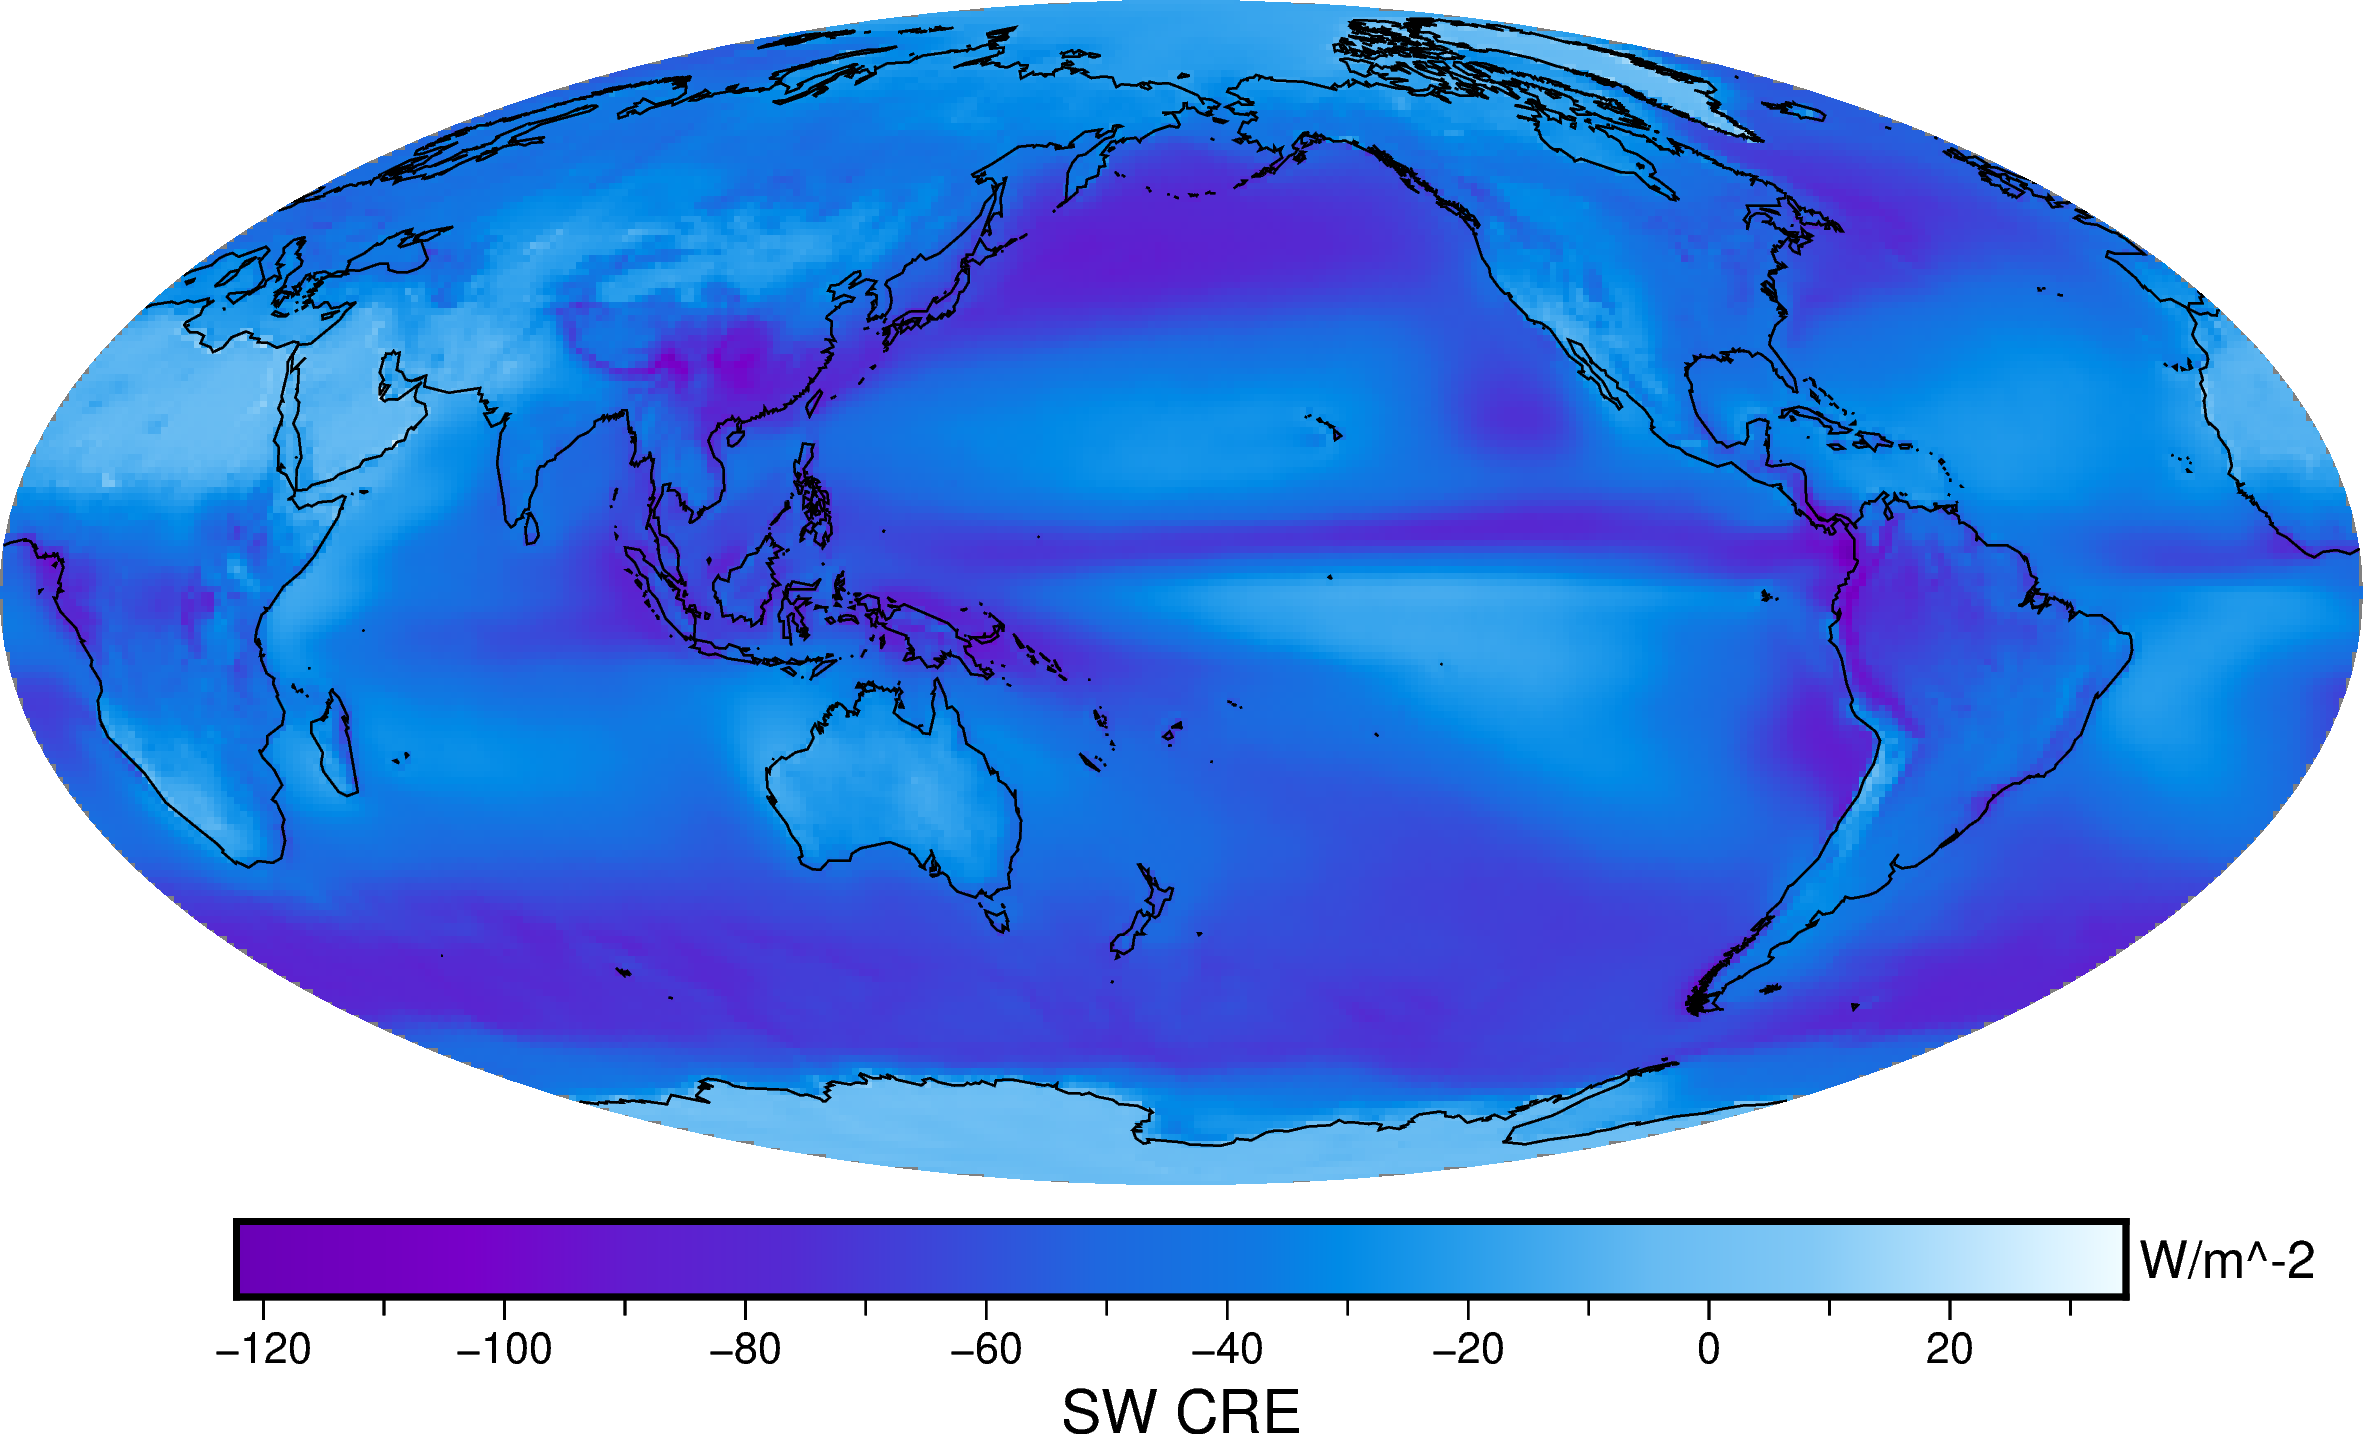

In [33]:
# PyGMT basic figure

fig = pygmt.Figure()  # open the Figure object

# to set limits on the color, need to "clip" the "grid"
grid = pygmt.grdclip(s, below=[-125, -125], above=[-25,-25]) # below -125, set to -125, above -25 to -25
fig.grdimage(grid=s, projection="W20c", cmap="seafloor")
# projection: W = Mollweide, 20c is 20 cm figsize
fig.coast(shorelines="1/0.5p,black,solid", borders=None, area_thresh=100)
fig.colorbar(frame=[f"x+lSW CRE", f"y+lW/m^{-2}"])
fig.show()

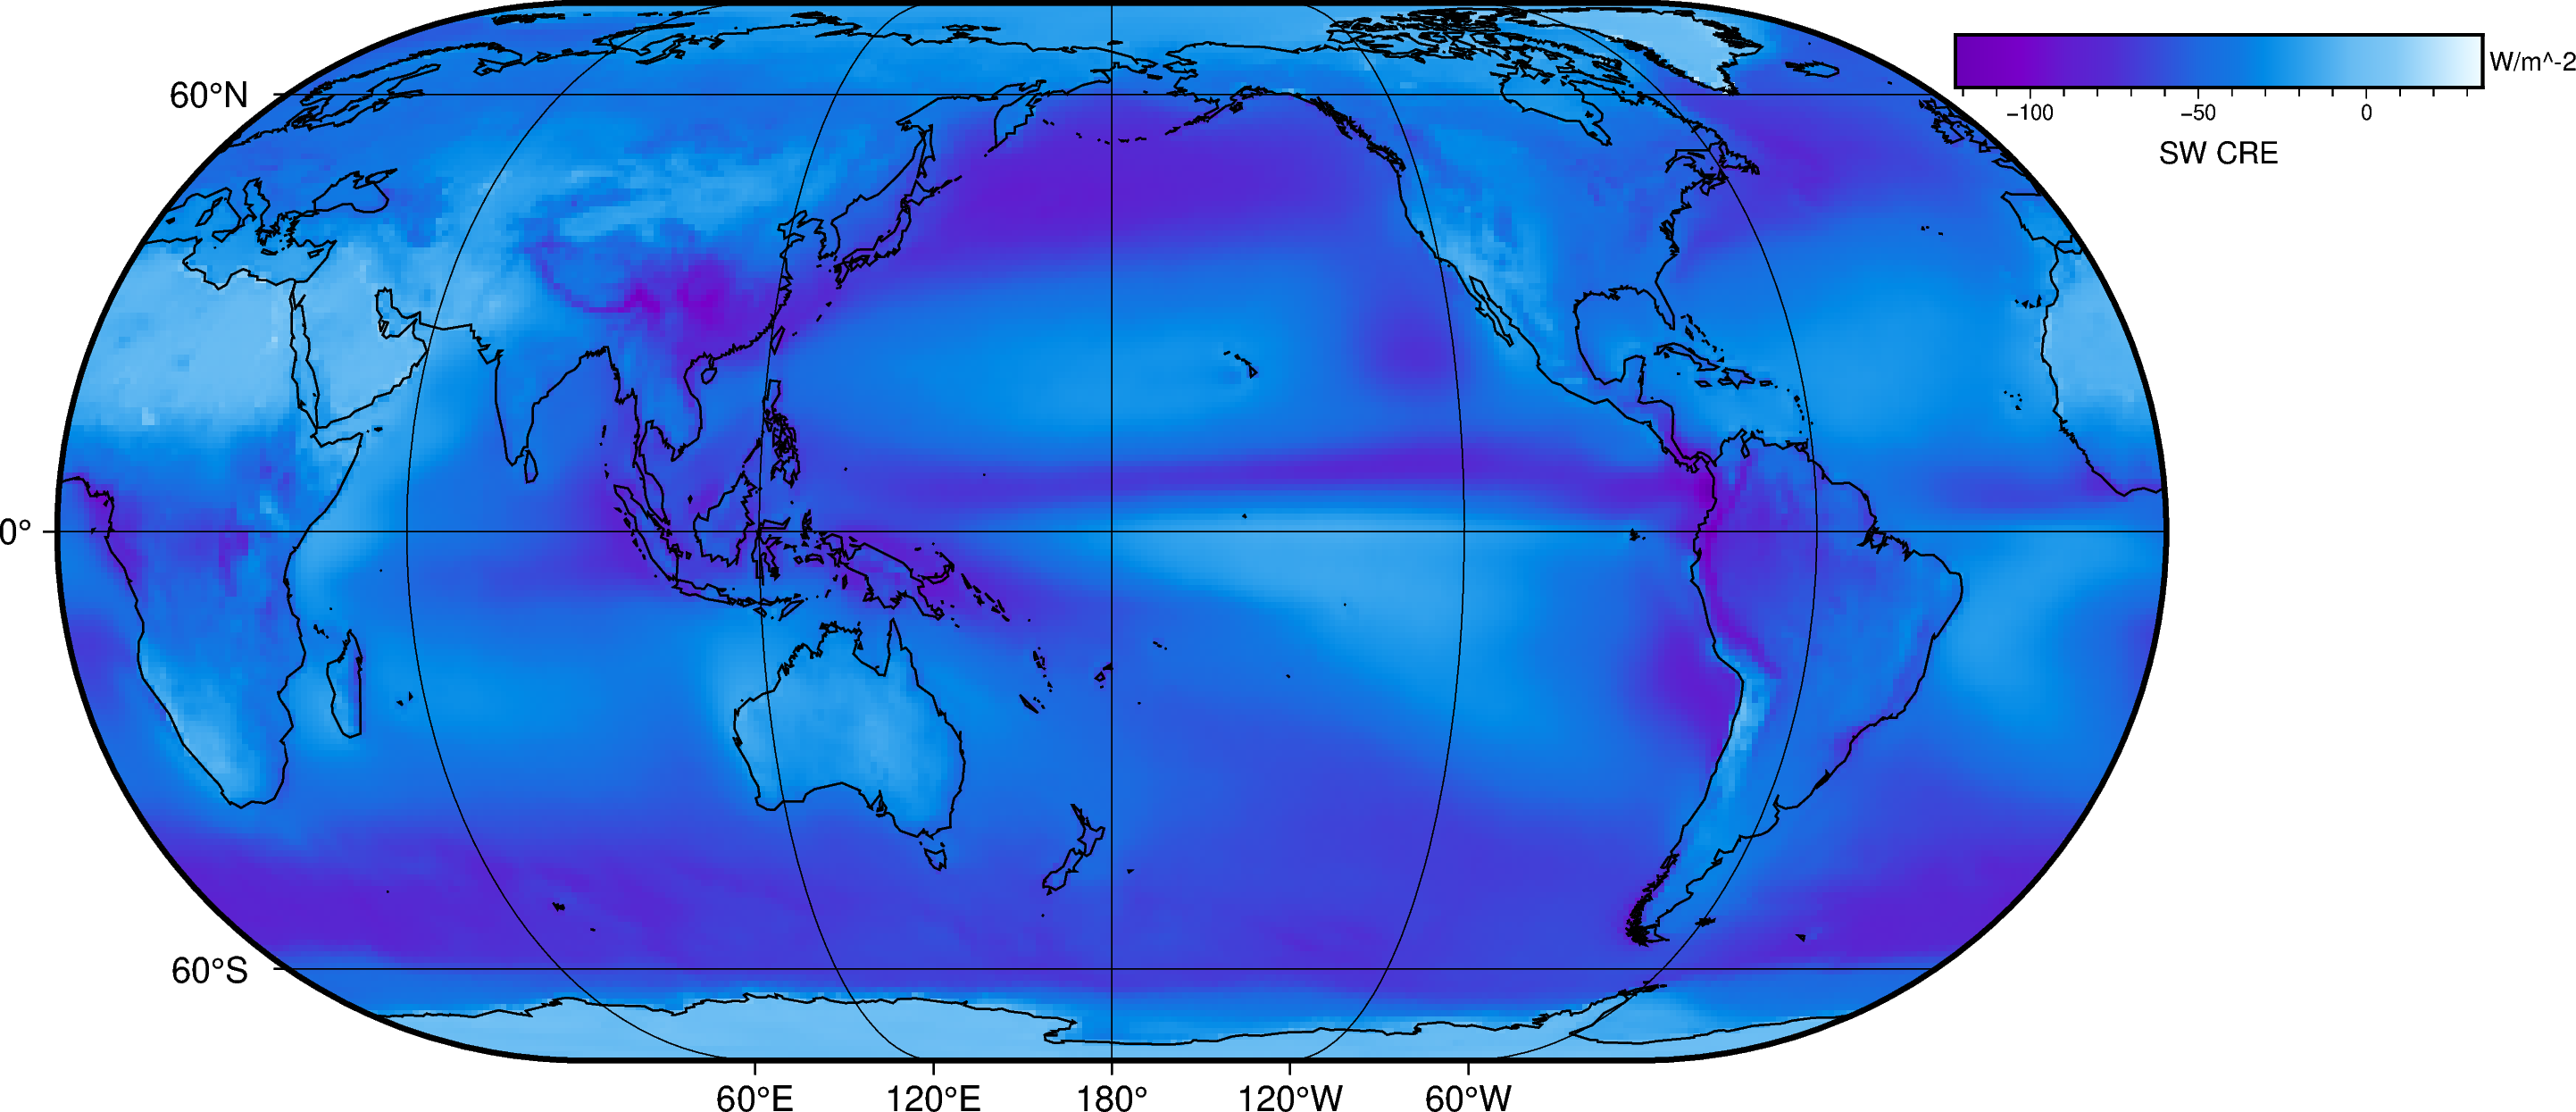

In [34]:
# PyGMT basic figure 2

fig = pygmt.Figure()  # open the Figure object

# to set limits on the color, need to "clip" the "grid"
grid = pygmt.grdclip(s, below=[-125, -125], above=[-25,-25]) # below -125, set to -125, above -25 to -25
fig.grdimage(grid=s, projection="Kf20c", cmap="seafloor", frame='ag')
# projection: W = Mollweide, 20c is 20 cm figsize
fig.coast(shorelines="1/0.5p,black,solid", borders=None, area_thresh=100)
fig.colorbar(frame=[f"x+lSW CRE", f"y+lW/m^{-2}"], position="n0.9/.92+h+w5/.5")
fig.show()

### PyGMT comments

_For me_ the pyGMT syntax seems arcane. It has been difficult for me to come to grips with their approach. But the plots are nice, and the mapping functionality is great.  I have a slightly more detailed set of examples, which I will put into the AMP_toolbox repo.

An extra detail: while experimenting, sometimes I have used the wrong syntax for pyGMT options, and sometimes it seems like that ends up sending something bad to the underlying GMT software that makes a Jupyter notebook hang. I'm not sure if that's because the notebook is waiting for GMT to return something or what... but it sometimes meant having to restart the kernel.

## NCL colormaps in Matplotlib

I have code that converts all the NCL colormaps to matplotlib versions. 

Here I'll show how to accomplish this and use it.

But I subsequently found that "Colormaps" package, which has also converted the NCL colormaps. So if you need them, it might be easiest to use that package.


### Converting NCL's .rgb files to mpl colormap

To create "exact" replicas of the NCL colormaps, I downloaded the `.rgb` files from the NCL website.

Here I'll use the `nrl_sirkes` colormap as an example, and assume we have a file called `nrl_sirkes.rgb`. 

I've done this for all the NCL colormaps, but that led to a number of complications being added because the NCL files are not consistent in their formatting. Some have RGB values as integers (0-255), some as decimal [0-1], and the header rows in the files vary a little bit, and some of the files have "comments" added, which usually start with "#" but at least one uses "/#". So the `ncl_to_mpl` function checks the values, but that's already after doing the reading of the file which has a regex to deal with the comments. 

In [35]:
def ncl_to_mpl(nclmap, name):
    if nclmap.max() > 1:
        try:
            vals = nclmap / 255
        except:
            print(f"ERROR: could not divide by 255. {type(nclmap) = }")
            print(nclmap)
            return None
    else:
        print(f"{name} seems to be 0-1")
        vals = nclmap
    assert vals.shape[1] == 3, 'vals.shape should be (N,3)'
    ncolors = vals.shape[0]
    if ncolors > 100:
        my_cmap = mpl.colors.LinearSegmentedColormap.from_list(name, vals)
        my_cmap_r = my_cmap.reversed()
    else:
        my_cmap = mpl.colors.ListedColormap(vals, name)
        my_cmap_r = my_cmap.reversed()
    # my_cmap, my_cmap_r from reversing a colormap
    # ALLOW MPL TO KNOW ABOUT THE COLORMAP:
    # mpl.colormaps.register(cmap=my_cmap)
    # mpl.colormaps.register(cmap=my_cmap_r)
    return my_cmap, my_cmap_r


In [36]:
# convert NCL colormap to matplotlib

ncl_cmap_file = "/Users/brianpm/Code/AMP_toolbox/ncl_colormaps_in_mpl/nrl_sirkes.rgb"

import re
with open(ncl_cmap_file) as f:
    table_exists = False
    for count, line in enumerate(f):
        line_str = line.strip() # remove leading/trailing whitespace
        if (len(line_str) == 0) or (not line_str[0].isdigit()):
            continue # empty line or non-data line 
            # NOTE: also skips if the first value is negative (hlu_default) 
        else:
            if re.search(r'[^\s0-9-\.]', line_str): # any non number characters ASSUMED AT END
                # take the string up to the non-matching character
                line_vals = line_str[:re.search(r'[^\s0-9-\.]', line_str).start()-1].strip().split()
            else:
                line_vals = line_str.split()
            try: 
                row = [float(r) for r in line_vals]
            except:
                print("ERROR")
                print(line_vals)
            if table_exists:
                table = np.vstack([table, row])
            else:
                table = np.array(row)
                table_exists=True


cm, cmr = ncl_to_mpl(table, "nrl_sirkes")


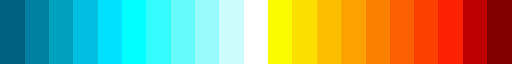

In [37]:
cm

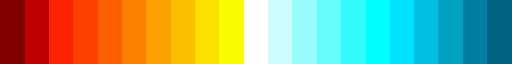

In [38]:
cmr

Text(0.5, 0.98, 'Using custom NCL-colormap')

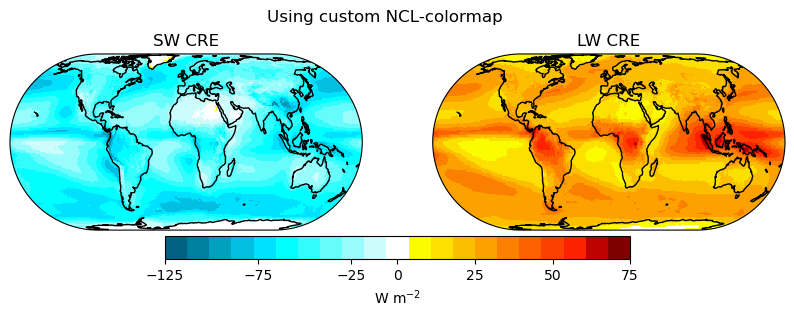

In [39]:
# example using it:
cnorm = mpl.colors.TwoSlopeNorm(vmin=-125, vcenter=0, vmax=75)

fig, ax = plt.subplots(figsize=(10,3), ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=cnorm, cmap=cm)
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=cnorm, cmap=cm)
ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]


cb = fig.colorbar(img2, ax=ax, shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 
cb.ax.set_xticks([-125, -75, -25, 0, 25, 50, 75])
fig.suptitle("Using custom NCL-colormap")

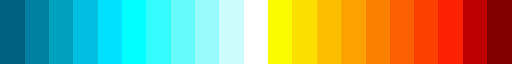

In [40]:
# Same thing, but now using that "colortables" package
import colormaps
colormaps.nrl_sirkes

Text(0.5, 0.98, 'Using `colormaps`')

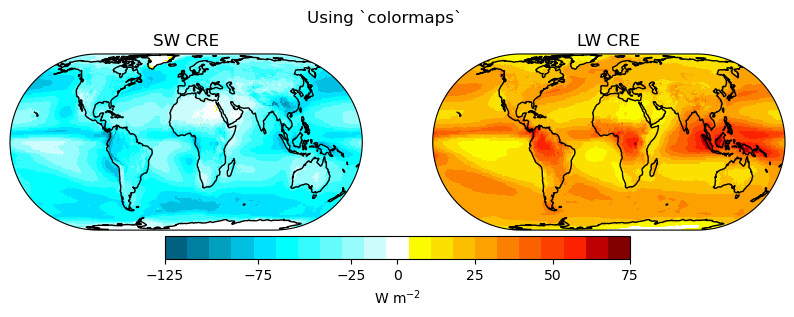

In [41]:
# Example figure with NCL colormap

cnorm = mpl.colors.TwoSlopeNorm(vmin=-125, vcenter=0, vmax=75)

fig, ax = plt.subplots(figsize=(10,3), ncols=2, subplot_kw={"projection":ccrs.EckertIV()})
img1 = ax[0].pcolormesh(longrid, latgrid, s, transform=ccrs.PlateCarree(), norm=cnorm, cmap=colormaps.nrl_sirkes)
img2 = ax[1].pcolormesh(longrid, latgrid, t, transform=ccrs.PlateCarree(), norm=cnorm, cmap=colormaps.nrl_sirkes)
ax[0].set_title("SW CRE")
ax[1].set_title("LW CRE")
[a.coastlines() for a in ax]


cb = fig.colorbar(img2, ax=ax, shrink=0.6, label='W m$^{-2}$', orientation='horizontal', pad=0.025) 
cb.ax.set_xticks([-125, -75, -25, 0, 25, 50, 75]);

fig.suptitle("Using `colormaps`")